In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import mlflow
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

## ml flow setup

In [3]:
mlflow.set_experiment("MultiLabel_EDA")

2025/08/06 10:36:48 INFO mlflow.tracking.fluent: Experiment with name 'MultiLabel_EDA' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/wd/wd_demos/toxic_comment_classification/notebooks/mlruns/365461217584339427', creation_time=1754469408567, experiment_id='365461217584339427', last_update_time=1754469408567, lifecycle_stage='active', name='MultiLabel_EDA', tags={}>

In [4]:
with mlflow.start_run(run_name="label_analysis"):
    # Ruta base: notebooks/ -> sube un nivel y entra a src/data/raw
    base_dir = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
    data_dir = base_dir / "src" / "data" / "raw"
    
    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    
    labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    
    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}")

Train shape: (159571, 8)
Test shape: (153164, 2)


In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


## STATISTICS

In [7]:
print("Label Distribution")
label_counts = train[labels].sum()
label_percentages = (label_counts / len(train)) * 100

for label, count, pct in zip(labels, label_counts, label_percentages):
    print(f"{label}: {count} ({pct:.2f}%)")
    mlflow.log_metric(f"{label}_percentage", pct)

Label Distribution
toxic: 15294 (9.58%)
severe_toxic: 1595 (1.00%)
obscene: 8449 (5.29%)
threat: 478 (0.30%)
insult: 7877 (4.94%)
identity_hate: 1405 (0.88%)


As we can observe, the dataset is imbalanced

## LABEL CO-OCCURRENCE ANALYSIS


In [8]:
from itertools import combinations
print("Label Co-occurrence")
cooccurrence = {}

Label Co-occurrence


In [9]:
for label1, label2 in combinations(labels, 2):
    mask = (train[label1] == 1) & (train[label2] == 1)
    count = mask.sum()
    cooccurrence[f"{label1}-{label2}"] = count


In [10]:
# Top co-occurrences
sorted_cooccur = sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)
for pair, count in sorted_cooccur[:10]:
    print(f"{pair}: {count}")

toxic-obscene: 7926
toxic-insult: 7344
obscene-insult: 6155
toxic-severe_toxic: 1595
severe_toxic-obscene: 1517
severe_toxic-insult: 1371
toxic-identity_hate: 1302
insult-identity_hate: 1160
obscene-identity_hate: 1032
toxic-threat: 449


Posible correlation between labels

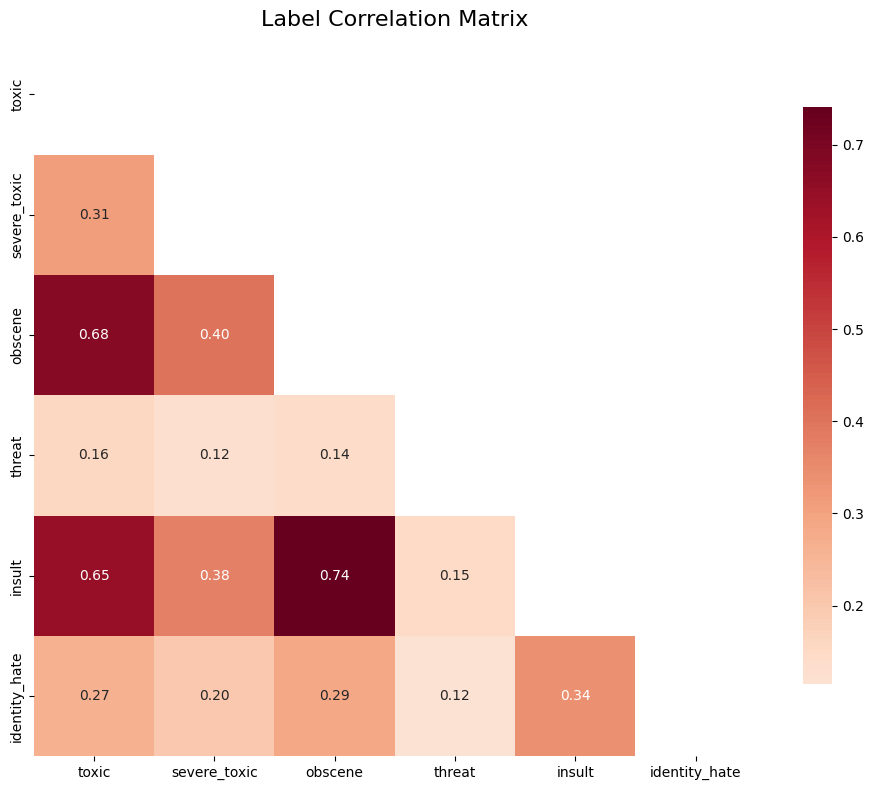

In [11]:
#correlation heatmap

plt.figure(figsize=(10, 8))
correlation_matrix = train[labels].corr()
# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    square=True,
    mask=mask,
    cbar_kws={"shrink": .8})

plt.title('Label Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.savefig('label_correlation.png', dpi=300)
mlflow.log_artifact('label_correlation.png')
plt.show()


## LABEL CARDINALITY DISTRIBUTION

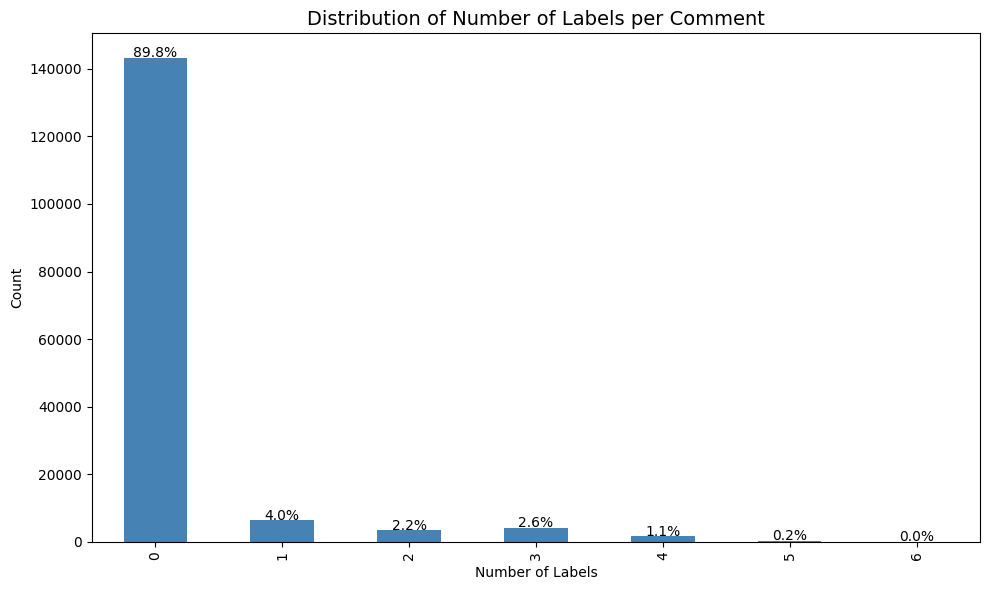

In [12]:
train['num_labels'] = train[labels].sum(axis=1)

plt.figure(figsize=(10, 6))
cardinality_dist = train['num_labels'].value_counts().sort_index()

ax = cardinality_dist.plot(kind='bar', color='steelblue')
plt.title('Distribution of Number of Labels per Comment', fontsize=14)
plt.xlabel('Number of Labels')
plt.ylabel('Count')

# Add percentage labels on bars
total = len(train)
for i, v in enumerate(cardinality_dist):
    ax.text(i, v + 100, f'{v/total*100:.1f}%', ha='center')
    
plt.tight_layout()
plt.savefig('label_cardinality.png', dpi=300)
mlflow.log_artifact('label_cardinality.png')
plt.show()

Majority of the comments non-toxic.

Imbalanced datset, risk of always predicting non-toxic.

The ocurrence of more than one label is rare.

## TEXT LENGTH ANALYSIS BY LABEL COMBINATION

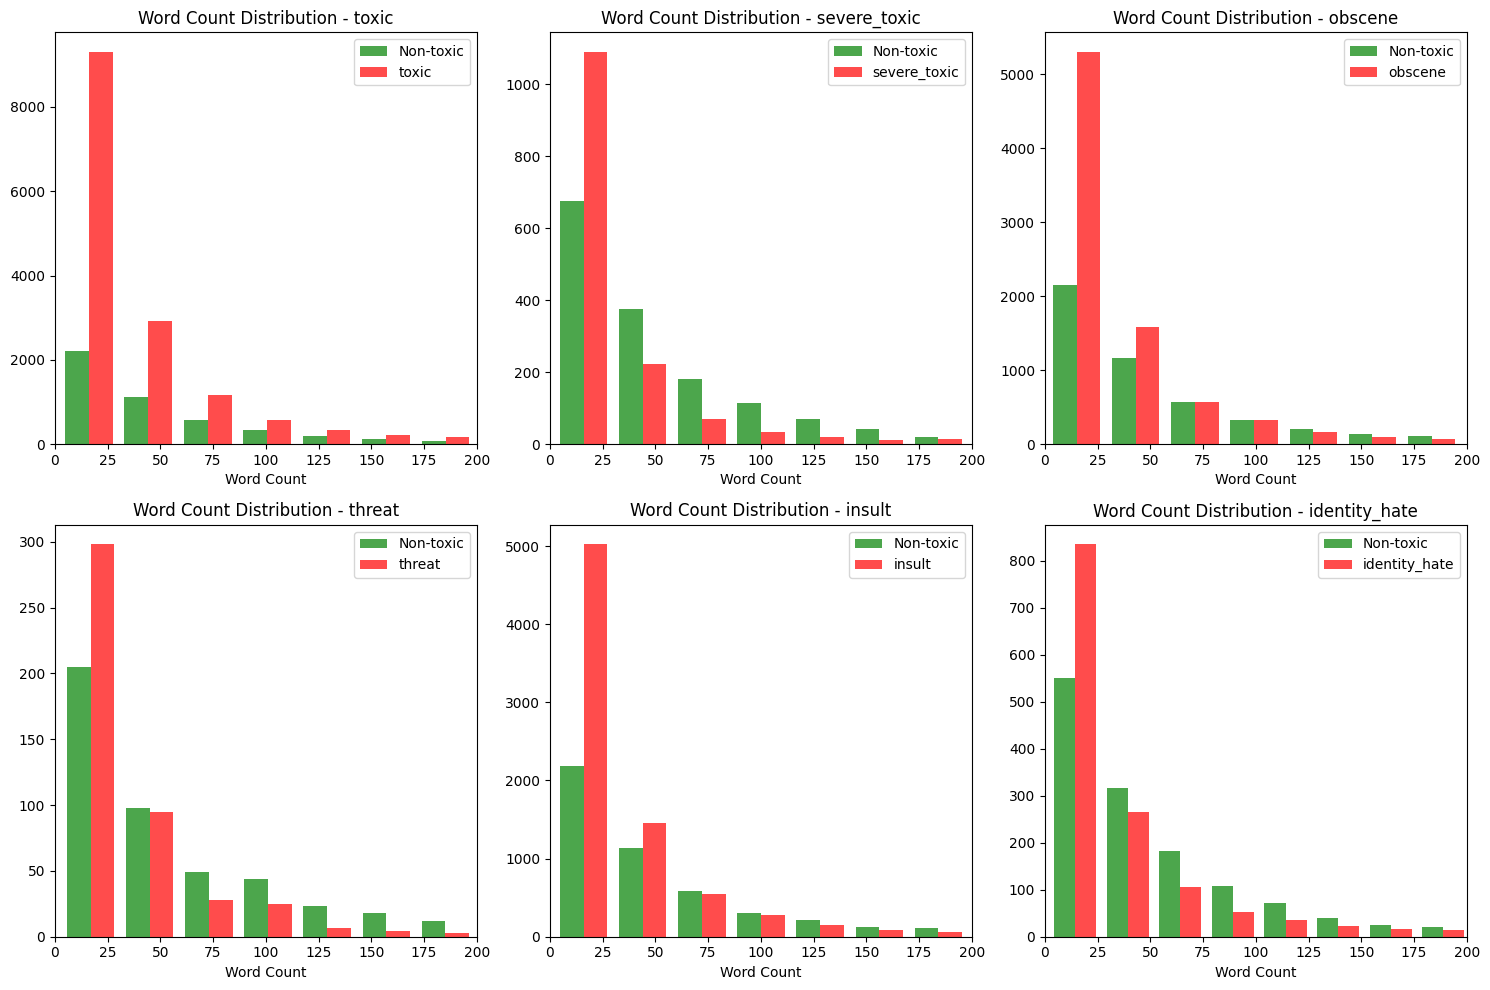

In [14]:
train['text_length'] = train['comment_text'].str.len()
train['word_count'] = train['comment_text'].str.split().str.len()

# Analyze text length for different label combinations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, label in enumerate(labels):
    positive_texts = train[train[label] == 1]['word_count']
    negative_texts = train[train[label] == 0]['word_count'].sample(min(len(positive_texts), 5000))
    
    axes[idx].hist([negative_texts, positive_texts], 
                    bins=50, 
                    alpha=0.7, 
                    label=['Non-toxic', label],
                    color=['green', 'red'])
    axes[idx].set_title(f'Word Count Distribution - {label}')
    axes[idx].set_xlabel('Word Count')
    axes[idx].legend()
    axes[idx].set_xlim(0, 200)

plt.tight_layout()
plt.savefig('word_count_by_label.png', dpi=300)
mlflow.log_artifact('word_count_by_label.png')
plt.show()

The majority of comments have fewer than 50 words, and the frequency drops off quickly as word count increases.

In every case, the red bars (toxic) are higher in the lowest word count bins (especially 0–25 words).
This suggests that toxic comments are often brief and direct.


As comment length increases, the difference between toxic and non-toxic narrows. In higher word count bins, the green and red bars are similar, or sometimes the green (non-toxic) bar is even higher.


**MODELING IMPLICATIONS:**
Toxic comments are usually shorter, so word count could be a helpful feature for the model.
Less frequent classes (threat, identity_hate) have fewer examples and less clear patterns, this may make them harder to detect.


## SAMPLE TOXIC COMMENTS BY PATTERN

In [15]:
print("Example Comments by Label Pattern")

# Single label examples
for label in labels:
    mask = (train[label] == 1) & (train[labels].sum(axis=1) == 1)
    if mask.sum() > 0:
        print(f"\n--- Only {label} ---")
        sample = train[mask].sample(min(2, mask.sum()))
        for text in sample['comment_text'].values:
            print(f"→ {text[:150]}...")

# Multi-label examples
toxic_obscene = (train['toxic'] == 1) & (train['obscene'] == 1)
if toxic_obscene.sum() > 0:
    print("\n--- Toxic + Obscene ---")
    sample = train[toxic_obscene].sample(min(2, toxic_obscene.sum()))
    for text in sample['comment_text'].values:
        print(f"→ {text[:150]}...")

Example Comments by Label Pattern

--- Only toxic ---
→ Hi, the Greek pages are a disgrace. The demographics section was written some time ago with correct data and many links to support them, and they have...
→ Why the heck are you putting Pink Floyd in the 250 million bracket when the citation you're using claims 200 million? Stop reverting....

--- Only obscene ---
→ "

 Anthropogenic Heat 

I created a new article. But I'm not sure it isn't already placed somewhere else under another name? Can you guys check it ou...
→ QUIT Threatening Me... 

Beyotch!!...

--- Only threat ---
→ Our warning to you ,Weare  not afraid of you blocking our edits here ,and if you keep going with this Nationalist propaganda Chauvinism and Hate speec...
→ "

New Award

Well Done!!!

  The IAmTheCoinMan You Are Really Annoying And You Are Good At Anti-Vandalism Barnstar I, , award you the The IAmTheCoinM...

--- Only insult ---
→ Is the Ellie Chronicals going to continue and why did he make it??? 

DEAR BM